### Задание 1
Retention – один из самых важных показателей в компании.  
Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [1]:
import pandas as pd
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

 ### Data preparation

In [2]:
# данные о регистрации

reg_data = pd.read_csv('Data/problem1-reg_data.csv', sep = ';')
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [3]:
reg_data.shape

(1000000, 2)

In [4]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [5]:
# теперь посмотрим на данные о посещениях 

auth_data = pd.read_csv('Data/problem1-auth_data.csv', sep = ';')

In [6]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [7]:
auth_data.shape

(9601013, 2)

In [8]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [9]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

### Retention function

In [10]:
# retention function

def retention(reg_data, auth_data):
    
    # переведём unit-time в дату и соединим таблички:
    reg_data.reg_ts = pd.to_datetime(reg_data.reg_ts, unit = 's').dt.date
    auth_data.auth_ts = pd.to_datetime(auth_data.auth_ts, unit = 's').dt.date
    auth_data  = pd.merge(auth_data, reg_data, on = 'uid', how = 'inner')
    
    # добавим колонку с номером дня, когда пользователь заходил в игру после регистрации 
    # (день регистрации - это 0 день) 
    auth_data['CohortPeriod'] = (auth_data['auth_ts'] - auth_data['reg_ts']).dt.days 
    
    # найдём размер когорты по дате регистрации
    cohort_data = auth_data.groupby(['reg_ts', 'CohortPeriod'])['uid'].nunique().reset_index()
    cohort_data = cohort_data.rename(columns = {'reg_ts' : 'Cohort'})
    cohort_counts = cohort_data.pivot(index = 'Cohort', columns = 'CohortPeriod', values = 'uid') # сводная таблица
    
    zero_day = cohort_counts[0] # нулевой день
    retention = cohort_counts.divide(zero_day, axis = 0).round(3)
    
    # heart map при помощи pandas.style
    visualization = (retention
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap = 'viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep = ""))  # числа форматируем как проценты, NaN заменяем на пустоту
    
    # таблица retention
    retention_rate = pd.DataFrame(retention)
    retention_rate = retention_rate.fillna(0)
    retention_mean = pd.DataFrame(round (retention_rate.mean() * 100, 2)).reset_index().rename(columns = {0 : 'retention'})
    
    # визуализируем retention по дням
    sns.set(font_scale = 1.85, style = "whitegrid",rc = {'figure.figsize':(20, 10)})
    sns.lineplot(x = retention_mean.CohortPeriod, y = retention_mean.retention).set_title("User retention rate by day")
    
    plt.show()
    
    return retention_mean, visualization
    
    
    

### Function testing

In [11]:
# приведём время регистрации к datetime и оставим только день 

reg_data['reg_date'] = pd.to_datetime(reg_data.reg_ts, unit='s').dt.date
#reg_data.rename(columns = {'reg_ts' : 'reg_date'}, inplace = True)
reg_data.head()

,reg_ts,uid,reg_date
0,911382223,1,1998-11-18
1,932683089,2,1999-07-22
2,947802447,3,2000-01-13
3,959523541,4,2000-05-28
4,969103313,5,2000-09-16


In [12]:
# оставим только тех пользоватлей, которые зарегистрировались в сентябре 2020 года 

reg_data_september = reg_data[reg_data['reg_date'] >= datetime.date(2020,9,1)]
reg_data_september.head()

,reg_ts,uid,reg_date
963460,1598918413,1070035,2020-09-01
963461,1598918468,1070036,2020-09-01
963462,1598918522,1070037,2020-09-01
963463,1598918577,1070038,2020-09-01
963464,1598918631,1070039,2020-09-01


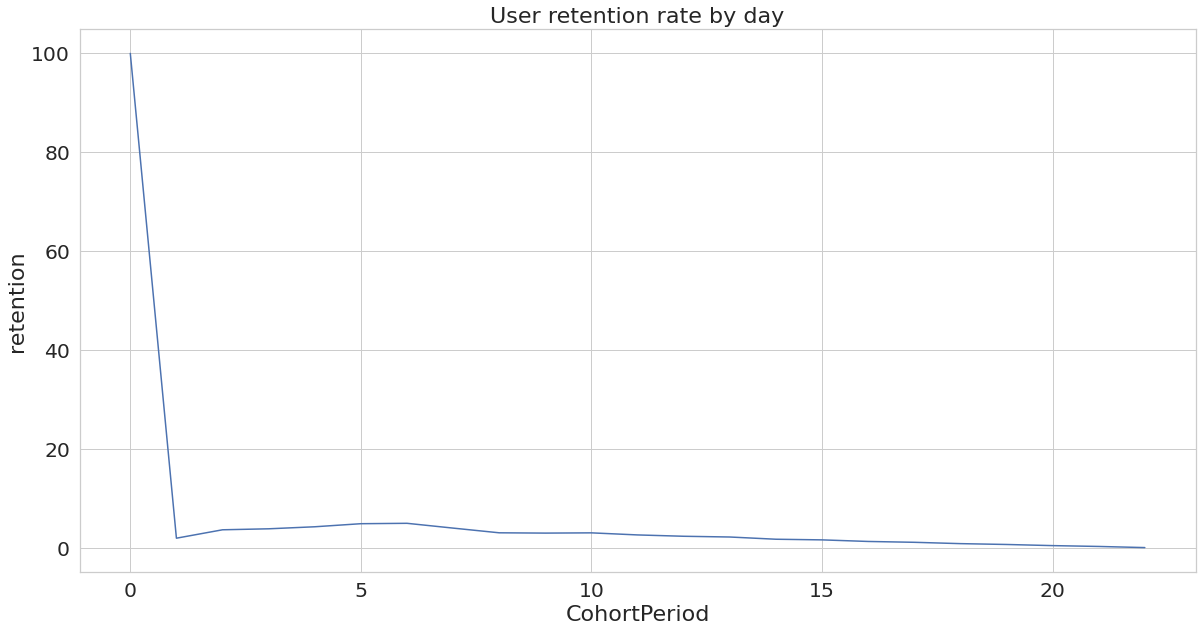

In [13]:
# протестируем функцию

table, heart_map = retention(reg_data_september, auth_data) 

In [14]:
table

,CohortPeriod,retention
0,0,100.00
1,1,1.97
2,2,3.67
3,3,3.87
4,4,4.28
5,5,4.90
6,6,4.98
7,7,4.01
8,8,3.06
9,9,3.00


In [2]:
# посмотрим на retention каждой когорты
#heart_map